# COMP 4531 Final Project - Winter 2024

Team: Corey Munk and Kurt Meyer

Topic: Image Classification with the CIFAR-100 data set


The problem is well understood. In your final project, please utilize some pre-built models. While they are generally large and accurate, they should be used to establish the upper bound of performance. Then, demonstrate the detailed steps you took to develop your own model. Of course, using a random classifier to set a baseline is not meaningful.




# Load Packages and Data with some EDA

In [34]:
import numpy as np 
import tensorflow as tf

from matplotlib import pyplot as plt
from sklearn.dummy import DummyClassifier

from keras.datasets import cifar100
from keras.utils import to_categorical

from sklearn.datasets import load_digits
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

import warnings

warnings.filterwarnings('ignore', category=DeprecationWarning, module='tensorflow')
# warnings.filterwarnings('default')

print('Tensor Flow Version:', tf.__version__)

Tensor Flow Version: 2.15.0


In [57]:
# Load CIFAR-100 data
(x_train, y_train), (x_test, y_test) = cifar100.load_data() 

# normalize pixel values
x_train, x_test = x_train/255, x_test/255

#one hot encode labels
y_train = to_categorical(y_train, num_classes=100)
y_test = to_categorical(y_test, num_classes=100)

print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(50000, 32, 32, 3)
(50000, 100)
(10000, 32, 32, 3)
(10000, 100)


In [ ]:
# Show sample count by label to visualize the balance of the data
class_labels = y_train.flatten()

plt.figure(figsize=(10,5))
plt.hist(class_labels, bins=np.arange(0,101), alpha=.8, color='green', edgecolor='black')
plt.title(f'Sample Distribution in Classes for CIFAR-100 (n = {len(class_labels)})')
plt.xlabel('Class')
plt.ylabel('Sample Count')
plt.xticks(np.arange(0,101, step=5))
plt.show()


# Display an image from each class in the dataset
distinct_labels = np.unique(y_train)
fig, axes = plt.subplots(10, 10, figsize=(10, 10))

for i, label in enumerate(distinct_labels):
    # Get image and label
    idx = np.where(y_train == label)[0]
    random_index = np.random.choice(idx)
    image, label = x_train[random_index], y_train[random_index][0]
    
    # Define grid cell to place image
    row = i // 10
    col = i % 10
    
    # Display image in defined grid cell
    current_image = (image.reshape((32, 32, 3)) * 255).clip(0, 255).astype(int)
    axes[row, col].imshow(current_image, interpolation='nearest')
    axes[row, col].set_title(f"Label: {label}", fontsize=8)
    axes[row, col].axis('off')

plt.tight_layout()
plt.show()


In [98]:
from tensorflow.keras.layers import BatchNormalization

from tensorflow.keras.preprocessing.image import ImageDataGenerator
# Create an ImageDataGenerator with data augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True
)

from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-7)

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True)


In [100]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(32, 32, 3)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool2D((2,2)),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool2D((2,2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(.2),
    tf.keras.layers.Dense(100, activation='softmax')
])

model.compile(
    optimizer='adam', 
    loss='categorical_crossentropy', 
    metrics=['accuracy']
)

# model.summary()

In [106]:
hist = model.fit(
    x_train, y_train, 
    epochs=20, 
    verbose=False, 
    validation_data=(x_test, y_test), 
    callbacks=[
                reduce_lr
                # ,early_stopping
              ]
)

Training Performance:
Final Training Accuracy: 0.7255600094795227
Final Training Loss: 0.9122334122657776


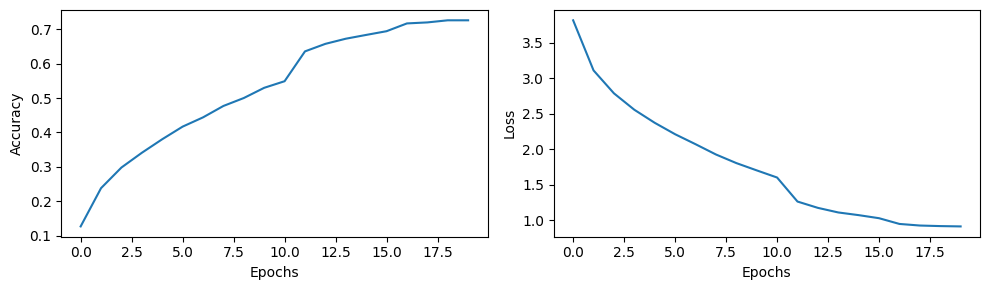

In [107]:
print('Training Performance:')
# print(hist.history)

final_train_accuracy = hist.history['accuracy'][-1]
final_train_loss = hist.history['loss'][-1]

print(f"Final Training Accuracy: {final_train_accuracy}")
print(f"Final Training Loss: {final_train_loss}")

plt.figure(figsize=(10, 3))

# plot accuracy
plt.subplot(1, 2, 1)
plt.plot(hist.history['accuracy'])
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

# plot loss
plt.subplot(1, 2, 2)
plt.plot(hist.history['loss'])
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.tight_layout()
plt.show()

In [108]:
print('Model Performance on Test Data:')
model.evaluate(x_test, y_test, verbose=2)

Model Performance on Test Data:
313/313 - 1s - loss: 2.8716 - accuracy: 0.3939 - 709ms/epoch - 2ms/step


[2.8716070652008057, 0.3939000070095062]

In [ ]:
model.save('cifar100_model.h5')

In [ ]:
# def plot( x=x_train, y=y_train, idx=1, yh=''):
#     plt.imshow(x[idx], cmap='Greys')
#     plt.title(f'label: {y[idx]}, pred: {yh}')
#     plt.tick_params(left=False, labelleft=False, labelbottom=False, bottom=False)

# pred = model(x_train[:1]).numpy()

# p1 = np.argmax(pred)
# p2 = np.argmax(tf.nn.softmax(pred).numpy())

# plot(x_train, y_train, 1, [p1,p2])